In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Prepare the data

Data were loaded and cleaned. The texts were converted to lower case; all punctuation marks were removed.

In [2]:
import string

titles = pd.read_csv("./data/medium_post_titles.csv")
titles.drop(columns=["subtitle", "subtitle_truncated_flag"], inplace=True)

titles.title = titles.title.str.replace('[{}]'.format(string.punctuation), '').str.lower()
titles.title = titles.title.str.replace('‘', '')
titles.title = titles.title.str.replace('’', '')
titles.title = titles.title.str.replace('“', '')
titles.title = titles.title.str.replace('”', '')
titles.title = titles.title.str.replace('—', '')

titles.head()

,category,title
0,work,21 conversations a fun and easy game for team...
1,spirituality,biblical porn at mars hill
2,lgbtqia,cisgender is that a disease
3,equality,call me nat love black cowboys and the frontie...
4,artificial-intelligence,can i train my model on your computer


20% of the data were held out as test set.

In [3]:
from sklearn.model_selection import train_test_split

titles_train, titles_test = train_test_split(titles, train_size=0.8, stratify=titles.category.values)

X_train = titles_train.title.str.split().tolist()
X_test = titles_test.title.str.split().tolist()

y_train = titles_train.category.values
y_test = titles_test.category.values

Categorical labels were converted to one-hot vector representations.

In [4]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

integer_encoder = LabelEncoder()
integer_train = integer_encoder.fit_transform(y_train).reshape((-1, 1))
integer_test = integer_encoder.transform(y_test).reshape((-1, 1))

onehot_encoder = OneHotEncoder(sparse=False)
onehot_train = onehot_encoder.fit_transform(integer_train)
onehot_test = onehot_encoder.transform(integer_test)

We used the continuous bag-of-words model to generate Word2vec embeddings. The continuous bag-of-words method trains a network that can predict the target word given the contextual words around it in the corpus. Word2vec project each word into a high-dimension vector space where contextually close words are located spatially closely.

Here, individual words, which appeared more than (including) twice in the data in the training set, were mapped to 128-dimension vectors, while the algorithm utilized the 6 words around it in the text as the context. We then coverted the titles in both the training and test sets to sequences of vectors where each vector represents a word. Novel words that were not included in the vocabulary during training were mapped to a vector with all elements equal to 0.

As the titles were not of equal length, padding was needed. All titles were pre-padded with vectors where all elements are set to 0 so they all have the same length in the final vector-sequence representations.

In [6]:
from itertools import chain

def extractVocabulary(titles, min_count):
    
    flatten_titles = list(chain(*titles))
    
    vocabulary, counts = np.unique(flatten_titles, return_counts=True)
    vocabulary = vocabulary[counts >= min_count]
    
    return vocabulary

In [7]:
from gensim.sklearn_api import W2VTransformer

vectorLength = 128
vectorizer = W2VTransformer(size=vectorLength, window=3, min_count=2, null_word=1, workers=-2, iter=500)
vectorizer.fit(X_train)
vocabulary = extractVocabulary(X_train, 2)

In [8]:
def mapTitle2Vectors(title, vectorizer, vocabulary, vectorSize, maxLength):
    
    vectorsMatrix = np.zeros((maxLength, vectorSize))
    nWords = len(title)
    prePadLength = maxLength - nWords
    for i, word in enumerate(title):
        if word in vocabulary:
            vectorsMatrix[prePadLength + i, :] = vectorizer.transform(word)
            
    return vectorsMatrix

In [9]:
from multiprocessing import Pool
from multiprocessing import cpu_count
from functools import partial

def mapTitles2Vectors(titles, vectorizer, vocabulary, vectorSize, maxLength):
    
    pool = Pool(cpu_count() - 1)
    
#     nTitles = len(titles)
    
#     representations = [[] for i in range(nTitles)]
#     for i, title in tqdm(enumerate(titles)):
#         representations[i] = mapTitle2Vectors(title, vectorizer, vocabulary, vectorSize, maxLength)
    
    mapTitle2Vectors_partial = partial(mapTitle2Vectors, vectorizer=vectorizer, vocabulary=vocabulary, vectorSize=vectorSize, maxLength=maxLength)
    representations = pool.map(mapTitle2Vectors_partial, titles)
    
    return np.concatenate(list(map(lambda mat: mat[np.newaxis, :], representations)), axis=0)

In [10]:
maxTitleLength = max(map(len, X_train + X_test))
vectors_train = mapTitles2Vectors(X_train, vectorizer, vocabulary, vectorLength, maxTitleLength)
vectors_test = mapTitles2Vectors(X_test, vectorizer, vocabulary, vectorLength, maxTitleLength)

# Recurrent neural network

In [11]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import SimpleRNN
from keras.layers import Dropout
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
from time import time

recurrentLayer = SimpleRNN(256, activation="relu", input_shape=(maxTitleLength, vectorLength))
fullyConnectedLayer1 = Dense(256, activation="relu")
fullyConnectedLayer2 = Dense(93, activation="softmax")

classifier0 = Sequential([recurrentLayer, fullyConnectedLayer1, fullyConnectedLayer2])
classifier0.compile(loss='categorical_crossentropy', optimizer="adam", metrics=["acc"])

early_stopping = EarlyStopping(monitor='val_acc', mode="max", patience=50, verbose=1)
best_model_saving = ModelCheckpoint("RNN_best_model_0.h5", monitor="val_acc", mode="max", save_best_only=True, verbose=1)

start_time = time()
history0 = classifier0.fit(vectors_train,onehot_train, epochs=5000, batch_size=2048, validation_data=(vectors_test,onehot_test), callbacks=[early_stopping, best_model_saving], verbose=2)
end_time = time()
print("Time elapsed during training: {}".format(end_time - start_time))

classifier0 = load_model("RNN_best_model_0.h5")

_, train_accuracy = classifier0.evaluate(vectors_train, onehot_train, verbose=0)
print("Accuracy on training set: {}".format(train_accuracy))
_, test_accuracy = classifier0.evaluate(vectors_test, onehot_test, verbose=0)
print("Accuracy on held-out test set: {}".format(test_accuracy))

Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Train on 101134 samples, validate on 25284 samples
Epoch 1/5000
 - 17s - loss: 4.3434 - acc: 0.0387 - val_loss: 4.1731 - val_acc: 0.0380

Epoch 00001: val_acc improved from -inf to 0.03801, saving model to RNN_best_model_0.h5
Epoch 2/5000
 - 15s - loss: 4.1603 - acc: 0.0400 - val_loss: 4.1569 - val_acc: 0.0401

Epoch 00002: val_acc improved from 0.03801 to 0.04010, saving model to RNN_best_model_0.h5
Epoch 3/5000
 - 16s - loss: 4.1576 - acc: 0.0395 - val_loss: 4.1568 - val_acc: 0.0401

Epoch 00003: val_acc did not improve from 0.04010
Epoch 4/5000
 - 16s - loss: 4.1576 - acc: 0.0398 - val_loss: 4.1561 - val_acc: 0.0400

Epoch 00004: val_acc did not improve from 0.04010
Epoch 5/5000
 - 17s - loss: 4.1569 - acc: 0.0401 - val_loss: 4.1556 - val_acc: 0.0400

Epoch 00005: val_acc did not improve from 0.04010
Epoch 6/5000
 - 15s - loss: 4.1566 - acc: 0.0397 - val_loss: 4.15

 - 16s - loss: 3.4718 - acc: 0.1670 - val_loss: 3.5911 - val_acc: 0.1528

Epoch 00047: val_acc did not improve from 0.15358
Epoch 48/5000
 - 16s - loss: 3.4667 - acc: 0.1685 - val_loss: 3.5696 - val_acc: 0.1546

Epoch 00048: val_acc improved from 0.15358 to 0.15460, saving model to RNN_best_model_0.h5
Epoch 49/5000
 - 15s - loss: 3.4461 - acc: 0.1707 - val_loss: 3.5441 - val_acc: 0.1587

Epoch 00049: val_acc improved from 0.15460 to 0.15868, saving model to RNN_best_model_0.h5
Epoch 50/5000
 - 15s - loss: 3.4258 - acc: 0.1743 - val_loss: 3.5463 - val_acc: 0.1595

Epoch 00050: val_acc improved from 0.15868 to 0.15947, saving model to RNN_best_model_0.h5
Epoch 51/5000
 - 15s - loss: 3.4214 - acc: 0.1757 - val_loss: 3.5557 - val_acc: 0.1573

Epoch 00051: val_acc did not improve from 0.15947
Epoch 52/5000
 - 15s - loss: 3.4137 - acc: 0.1772 - val_loss: 3.5317 - val_acc: 0.1606

Epoch 00052: val_acc improved from 0.15947 to 0.16062, saving model to RNN_best_model_0.h5
Epoch 53/5000
 - 16s -

 - 15s - loss: 3.0028 - acc: 0.2530 - val_loss: 3.4991 - val_acc: 0.1941

Epoch 00098: val_acc did not improve from 0.19684
Epoch 99/5000
 - 16s - loss: 2.9954 - acc: 0.2541 - val_loss: 3.4684 - val_acc: 0.1968

Epoch 00099: val_acc did not improve from 0.19684
Epoch 100/5000
 - 15s - loss: 2.9996 - acc: 0.2537 - val_loss: 3.4916 - val_acc: 0.1956

Epoch 00100: val_acc did not improve from 0.19684
Epoch 101/5000
 - 15s - loss: 2.9830 - acc: 0.2568 - val_loss: 3.4951 - val_acc: 0.1960

Epoch 00101: val_acc did not improve from 0.19684
Epoch 102/5000
 - 15s - loss: 2.9855 - acc: 0.2557 - val_loss: 3.4733 - val_acc: 0.1965

Epoch 00102: val_acc did not improve from 0.19684
Epoch 103/5000
 - 16s - loss: 2.9718 - acc: 0.2591 - val_loss: 3.4999 - val_acc: 0.1965

Epoch 00103: val_acc did not improve from 0.19684
Epoch 104/5000
 - 15s - loss: 2.9716 - acc: 0.2583 - val_loss: 3.5358 - val_acc: 0.1949

Epoch 00104: val_acc did not improve from 0.19684
Epoch 105/5000
 - 16s - loss: 2.9626 - acc:

 - 16s - loss: 2.7600 - acc: 0.2997 - val_loss: 3.6399 - val_acc: 0.1987

Epoch 00155: val_acc did not improve from 0.20143
Epoch 156/5000
 - 15s - loss: 2.7525 - acc: 0.3008 - val_loss: 3.6575 - val_acc: 0.1970

Epoch 00156: val_acc did not improve from 0.20143
Epoch 157/5000
 - 15s - loss: 2.7424 - acc: 0.3037 - val_loss: 3.6655 - val_acc: 0.1968

Epoch 00157: val_acc did not improve from 0.20143
Epoch 158/5000
 - 16s - loss: 2.7539 - acc: 0.3001 - val_loss: 3.6523 - val_acc: 0.1980

Epoch 00158: val_acc did not improve from 0.20143
Epoch 159/5000
 - 15s - loss: 2.7333 - acc: 0.3052 - val_loss: 3.6670 - val_acc: 0.1974

Epoch 00159: val_acc did not improve from 0.20143
Epoch 160/5000
 - 16s - loss: 2.7307 - acc: 0.3064 - val_loss: 3.6788 - val_acc: 0.1970

Epoch 00160: val_acc did not improve from 0.20143
Epoch 161/5000
 - 16s - loss: 2.7370 - acc: 0.3047 - val_loss: 3.6669 - val_acc: 0.1957

Epoch 00161: val_acc did not improve from 0.20143
Epoch 162/5000
 - 16s - loss: 2.7269 - acc

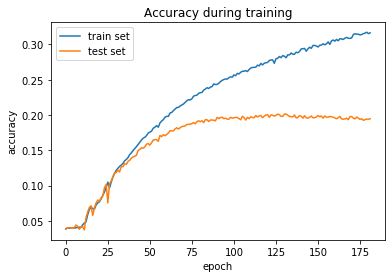

In [12]:
def plotFittingAccuracy(history):
    
    plt.plot(history.history['acc'], label='train set')
    plt.plot(history.history['val_acc'], label='test set')
    
    plt.title("Accuracy during training")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend()
    plt.show()
    
plotFittingAccuracy(history0)

Train on 101134 samples, validate on 25284 samples
Epoch 1/5000
 - 41s - loss: 4.3644 - acc: 0.0386 - val_loss: 4.1668 - val_acc: 0.0401

Epoch 00001: val_acc improved from -inf to 0.04010, saving model to RNN_best_model_1.h5
Epoch 2/5000
 - 40s - loss: 4.1596 - acc: 0.0393 - val_loss: 4.1565 - val_acc: 0.0401

Epoch 00002: val_acc did not improve from 0.04010
Epoch 3/5000
 - 39s - loss: 4.1575 - acc: 0.0402 - val_loss: 4.1583 - val_acc: 0.0401

Epoch 00003: val_acc did not improve from 0.04010
Epoch 4/5000
 - 40s - loss: 4.1572 - acc: 0.0401 - val_loss: 4.1559 - val_acc: 0.0401

Epoch 00004: val_acc did not improve from 0.04010
Epoch 5/5000
 - 40s - loss: 4.1569 - acc: 0.0400 - val_loss: 4.1550 - val_acc: 0.0400

Epoch 00005: val_acc did not improve from 0.04010
Epoch 6/5000
 - 40s - loss: 4.1556 - acc: 0.0397 - val_loss: 4.1579 - val_acc: 0.0378

Epoch 00006: val_acc did not improve from 0.04010
Epoch 7/5000
 - 40s - loss: 4.1547 - acc: 0.0391 - val_loss: 4.1538 - val_acc: 0.0400

Ep


Epoch 00050: val_acc did not improve from 0.19498
Epoch 51/5000
 - 40s - loss: 3.0465 - acc: 0.2416 - val_loss: 3.4075 - val_acc: 0.1984

Epoch 00051: val_acc improved from 0.19498 to 0.19839, saving model to RNN_best_model_1.h5
Epoch 52/5000
 - 40s - loss: 3.0382 - acc: 0.2436 - val_loss: 3.3976 - val_acc: 0.2004

Epoch 00052: val_acc improved from 0.19839 to 0.20044, saving model to RNN_best_model_1.h5
Epoch 53/5000
 - 40s - loss: 3.0177 - acc: 0.2474 - val_loss: 3.4114 - val_acc: 0.2011

Epoch 00053: val_acc improved from 0.20044 to 0.20112, saving model to RNN_best_model_1.h5
Epoch 54/5000
 - 40s - loss: 2.9916 - acc: 0.2519 - val_loss: 3.4963 - val_acc: 0.1937

Epoch 00054: val_acc did not improve from 0.20112
Epoch 55/5000
 - 40s - loss: 2.9987 - acc: 0.2507 - val_loss: 3.4661 - val_acc: 0.1975

Epoch 00055: val_acc did not improve from 0.20112
Epoch 56/5000
 - 40s - loss: 2.9608 - acc: 0.2569 - val_loss: 3.4145 - val_acc: 0.2027

Epoch 00056: val_acc improved from 0.20112 to 0.


Epoch 00107: val_acc did not improve from 0.20551
Epoch 108/5000
 - 40s - loss: 2.1738 - acc: 0.4250 - val_loss: 4.3371 - val_acc: 0.1929

Epoch 00108: val_acc did not improve from 0.20551
Epoch 109/5000
 - 39s - loss: 2.1946 - acc: 0.4208 - val_loss: 4.2713 - val_acc: 0.1850

Epoch 00109: val_acc did not improve from 0.20551
Epoch 110/5000
 - 40s - loss: 2.2151 - acc: 0.4135 - val_loss: 4.3026 - val_acc: 0.1925

Epoch 00110: val_acc did not improve from 0.20551
Epoch 111/5000
 - 40s - loss: 2.2465 - acc: 0.4061 - val_loss: 4.3257 - val_acc: 0.1904

Epoch 00111: val_acc did not improve from 0.20551
Epoch 112/5000
 - 40s - loss: 2.1738 - acc: 0.4231 - val_loss: 4.3543 - val_acc: 0.1921

Epoch 00112: val_acc did not improve from 0.20551
Epoch 113/5000
 - 40s - loss: 2.1472 - acc: 0.4317 - val_loss: 4.4120 - val_acc: 0.1883

Epoch 00113: val_acc did not improve from 0.20551
Epoch 114/5000
 - 40s - loss: 2.1366 - acc: 0.4331 - val_loss: 4.5453 - val_acc: 0.1904

Epoch 00114: val_acc did n

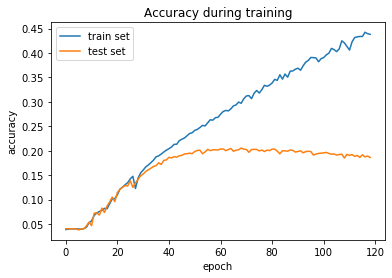

In [13]:
recurrentLayer = SimpleRNN(512, activation="relu", input_shape=(maxTitleLength, vectorLength))
fullyConnectedLayer1 = Dense(512, activation="relu")
fullyConnectedLayer2 = Dense(93, activation="softmax")

classifier1 = Sequential([recurrentLayer, fullyConnectedLayer1, fullyConnectedLayer2])
classifier1.compile(loss='categorical_crossentropy', optimizer="adam", metrics=["acc"])

early_stopping = EarlyStopping(monitor='val_acc', mode="max", patience=50, verbose=1)
best_model_saving = ModelCheckpoint("RNN_best_model_1.h5", monitor="val_acc", mode="max", save_best_only=True, verbose=1)

start_time = time()
history1 = classifier1.fit(vectors_train,onehot_train, epochs=5000, batch_size=2048, validation_data=(vectors_test,onehot_test), callbacks=[early_stopping, best_model_saving], verbose=2)
end_time = time()
print("Time elapsed during training: {}".format(end_time - start_time))

classifier1 = load_model("RNN_best_model_1.h5")

_, train_accuracy = classifier1.evaluate(vectors_train, onehot_train, verbose=0)
print("Accuracy on training set: {}".format(train_accuracy))
_, test_accuracy = classifier1.evaluate(vectors_test, onehot_test, verbose=0)
print("Accuracy on held-out test set: {}".format(test_accuracy))

plotFittingAccuracy(history1)

Train on 101134 samples, validate on 25284 samples
Epoch 1/5000
 - 40s - loss: 4.3856 - acc: 0.0377 - val_loss: 4.1743 - val_acc: 0.0401

Epoch 00001: val_acc improved from -inf to 0.04010, saving model to RNN_best_model_2.h5
Epoch 2/5000
 - 40s - loss: 4.1605 - acc: 0.0396 - val_loss: 4.1568 - val_acc: 0.0381

Epoch 00002: val_acc did not improve from 0.04010
Epoch 3/5000
 - 39s - loss: 4.1575 - acc: 0.0393 - val_loss: 4.1563 - val_acc: 0.0401

Epoch 00003: val_acc did not improve from 0.04010
Epoch 4/5000
 - 40s - loss: 4.1568 - acc: 0.0400 - val_loss: 4.1580 - val_acc: 0.0401

Epoch 00004: val_acc did not improve from 0.04010
Epoch 5/5000
 - 39s - loss: 4.1563 - acc: 0.0399 - val_loss: 4.1555 - val_acc: 0.0400

Epoch 00005: val_acc did not improve from 0.04010
Epoch 6/5000
 - 40s - loss: 4.1556 - acc: 0.0405 - val_loss: 4.1549 - val_acc: 0.0403

Epoch 00006: val_acc improved from 0.04010 to 0.04034, saving model to RNN_best_model_2.h5
Epoch 7/5000
 - 40s - loss: 4.1556 - acc: 0.0391


Epoch 00050: val_acc improved from 0.16327 to 0.16702, saving model to RNN_best_model_2.h5
Epoch 51/5000
 - 41s - loss: 3.3716 - acc: 0.1862 - val_loss: 3.5194 - val_acc: 0.1677

Epoch 00051: val_acc improved from 0.16702 to 0.16773, saving model to RNN_best_model_2.h5
Epoch 52/5000
 - 47s - loss: 3.3518 - acc: 0.1894 - val_loss: 3.5047 - val_acc: 0.1723

Epoch 00052: val_acc improved from 0.16773 to 0.17228, saving model to RNN_best_model_2.h5
Epoch 53/5000
 - 44s - loss: 3.3309 - acc: 0.1925 - val_loss: 3.5084 - val_acc: 0.1717

Epoch 00053: val_acc did not improve from 0.17228
Epoch 54/5000
 - 43s - loss: 3.3211 - acc: 0.1950 - val_loss: 3.5019 - val_acc: 0.1729

Epoch 00054: val_acc improved from 0.17228 to 0.17292, saving model to RNN_best_model_2.h5
Epoch 55/5000
 - 41s - loss: 3.3034 - acc: 0.1979 - val_loss: 3.4899 - val_acc: 0.1736

Epoch 00055: val_acc improved from 0.17292 to 0.17363, saving model to RNN_best_model_2.h5
Epoch 56/5000
 - 42s - loss: 3.2849 - acc: 0.2017 - va


Epoch 00102: val_acc did not improve from 0.19696
Epoch 103/5000
 - 37s - loss: 2.6966 - acc: 0.3114 - val_loss: 3.6811 - val_acc: 0.1925

Epoch 00103: val_acc did not improve from 0.19696
Epoch 104/5000
 - 38s - loss: 2.6870 - acc: 0.3134 - val_loss: 3.6796 - val_acc: 0.1927

Epoch 00104: val_acc did not improve from 0.19696
Epoch 105/5000
 - 38s - loss: 2.6833 - acc: 0.3135 - val_loss: 3.7077 - val_acc: 0.1963

Epoch 00105: val_acc did not improve from 0.19696
Epoch 106/5000
 - 37s - loss: 2.6606 - acc: 0.3200 - val_loss: 3.7920 - val_acc: 0.1947

Epoch 00106: val_acc did not improve from 0.19696
Epoch 107/5000
 - 37s - loss: 2.6591 - acc: 0.3207 - val_loss: 3.7584 - val_acc: 0.1941

Epoch 00107: val_acc did not improve from 0.19696
Epoch 108/5000
 - 37s - loss: 2.6441 - acc: 0.3227 - val_loss: 3.7883 - val_acc: 0.1938

Epoch 00108: val_acc did not improve from 0.19696
Epoch 109/5000
 - 38s - loss: 2.6333 - acc: 0.3244 - val_loss: 3.8035 - val_acc: 0.1922

Epoch 00109: val_acc did n

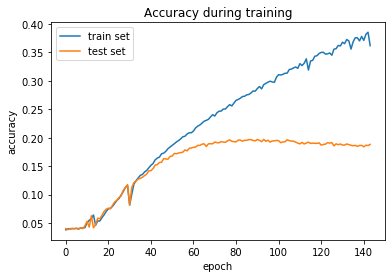

In [14]:
recurrentLayer = SimpleRNN(512, activation="relu", input_shape=(maxTitleLength, vectorLength))
fullyConnectedLayer1 = Dense(256, activation="relu")
fullyConnectedLayer2 = Dense(93, activation="softmax")

classifier2 = Sequential([recurrentLayer, fullyConnectedLayer1, fullyConnectedLayer2])
classifier2.compile(loss='categorical_crossentropy', optimizer="adam", metrics=["acc"])

early_stopping = EarlyStopping(monitor='val_acc', mode="max", patience=50, verbose=1)
best_model_saving = ModelCheckpoint("RNN_best_model_2.h5", monitor="val_acc", mode="max", save_best_only=True, verbose=1)

start_time = time()
history2 = classifier2.fit(vectors_train,onehot_train, epochs=5000, batch_size=2048, validation_data=(vectors_test,onehot_test), callbacks=[early_stopping, best_model_saving], verbose=2)
end_time = time()
print("Time elapsed during training: {}".format(end_time - start_time))

classifier2 = load_model("RNN_best_model_2.h5")

_, train_accuracy = classifier2.evaluate(vectors_train, onehot_train, verbose=0)
print("Accuracy on training set: {}".format(train_accuracy))
_, test_accuracy = classifier2.evaluate(vectors_test, onehot_test, verbose=0)
print("Accuracy on held-out test set: {}".format(test_accuracy))

plotFittingAccuracy(history2)

We first tested an architecture of two hidden layers, an RNN layer followed by a perceptron layer. The number of units in each layer were varied -- RNN-256-perceptron-256, RNN-512-perceptron-512 and RNN-512-perceptron-256. Three options performed identically on the test set with a accuracy of 20%. Thus, the RNN-256-perceptron-256 should be deemed a more computationally economical choice as increasing the size of hidden layers did not warrant better performance.

Train on 101134 samples, validate on 25284 samples
Epoch 1/5000
 - 36s - loss: 4.3894 - acc: 0.0395 - val_loss: 4.1684 - val_acc: 0.0378

Epoch 00001: val_acc improved from -inf to 0.03777, saving model to RNN_best_model_3.h5
Epoch 2/5000
 - 35s - loss: 4.1612 - acc: 0.0381 - val_loss: 4.1570 - val_acc: 0.0400

Epoch 00002: val_acc improved from 0.03777 to 0.03999, saving model to RNN_best_model_3.h5
Epoch 3/5000
 - 35s - loss: 4.1580 - acc: 0.0392 - val_loss: 4.1580 - val_acc: 0.0409

Epoch 00003: val_acc improved from 0.03999 to 0.04086, saving model to RNN_best_model_3.h5
Epoch 4/5000
 - 35s - loss: 4.1571 - acc: 0.0395 - val_loss: 4.1579 - val_acc: 0.0400

Epoch 00004: val_acc did not improve from 0.04086
Epoch 5/5000
 - 35s - loss: 4.1568 - acc: 0.0394 - val_loss: 4.1556 - val_acc: 0.0400

Epoch 00005: val_acc did not improve from 0.04086
Epoch 6/5000
 - 35s - loss: 4.1560 - acc: 0.0400 - val_loss: 4.1549 - val_acc: 0.0401

Epoch 00006: val_acc did not improve from 0.04086
Epoch 7

 - 35s - loss: 3.1209 - acc: 0.2197 - val_loss: 3.4227 - val_acc: 0.1836

Epoch 00051: val_acc did not improve from 0.18431
Epoch 52/5000
 - 35s - loss: 3.1276 - acc: 0.2181 - val_loss: 3.4383 - val_acc: 0.1833

Epoch 00052: val_acc did not improve from 0.18431
Epoch 53/5000
 - 35s - loss: 3.1019 - acc: 0.2235 - val_loss: 3.4427 - val_acc: 0.1819

Epoch 00053: val_acc did not improve from 0.18431
Epoch 54/5000
 - 35s - loss: 3.1049 - acc: 0.2218 - val_loss: 3.4186 - val_acc: 0.1870

Epoch 00054: val_acc improved from 0.18431 to 0.18704, saving model to RNN_best_model_3.h5
Epoch 55/5000
 - 35s - loss: 3.0840 - acc: 0.2256 - val_loss: 3.4801 - val_acc: 0.1822

Epoch 00055: val_acc did not improve from 0.18704
Epoch 56/5000
 - 35s - loss: 3.0851 - acc: 0.2250 - val_loss: 3.4706 - val_acc: 0.1863

Epoch 00056: val_acc did not improve from 0.18704
Epoch 57/5000
 - 35s - loss: 3.0690 - acc: 0.2291 - val_loss: 3.4377 - val_acc: 0.1858

Epoch 00057: val_acc did not improve from 0.18704
Epoch 5


Epoch 00107: val_acc did not improve from 0.20005
Epoch 108/5000
 - 35s - loss: 2.6828 - acc: 0.3034 - val_loss: 3.6221 - val_acc: 0.1955

Epoch 00108: val_acc did not improve from 0.20005
Epoch 109/5000
 - 35s - loss: 2.6819 - acc: 0.3050 - val_loss: 3.6176 - val_acc: 0.1962

Epoch 00109: val_acc did not improve from 0.20005
Epoch 110/5000
 - 35s - loss: 2.6834 - acc: 0.3028 - val_loss: 3.6671 - val_acc: 0.1957

Epoch 00110: val_acc did not improve from 0.20005
Epoch 111/5000
 - 35s - loss: 2.6834 - acc: 0.3043 - val_loss: 3.6746 - val_acc: 0.1939

Epoch 00111: val_acc did not improve from 0.20005
Epoch 112/5000
 - 35s - loss: 2.6648 - acc: 0.3076 - val_loss: 3.6365 - val_acc: 0.1955

Epoch 00112: val_acc did not improve from 0.20005
Epoch 113/5000
 - 35s - loss: 2.6498 - acc: 0.3113 - val_loss: 3.6948 - val_acc: 0.1949

Epoch 00113: val_acc did not improve from 0.20005
Epoch 114/5000
 - 35s - loss: 2.6738 - acc: 0.3044 - val_loss: 3.6543 - val_acc: 0.1938

Epoch 00114: val_acc did n

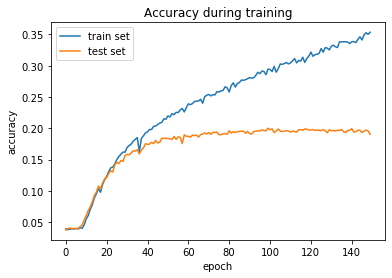

In [15]:
recurrentLayer1 = SimpleRNN(256, activation="relu", input_shape=(maxTitleLength, vectorLength), return_sequences=True)
recurrentLayer2 = SimpleRNN(256, activation="relu")
fullyConnectedLayer1 = Dense(256, activation="relu")
fullyConnectedLayer2 = Dense(93, activation="softmax")

classifier3 = Sequential([recurrentLayer1, recurrentLayer2, fullyConnectedLayer1, fullyConnectedLayer2])
classifier3.compile(loss='categorical_crossentropy', optimizer="adam", metrics=["acc"])

early_stopping = EarlyStopping(monitor='val_acc', mode="max", patience=50, verbose=1)
best_model_saving = ModelCheckpoint("RNN_best_model_3.h5", monitor="val_acc", mode="max", save_best_only=True, verbose=1)

start_time = time()
history3 = classifier3.fit(vectors_train,onehot_train, epochs=5000, batch_size=2048, validation_data=(vectors_test,onehot_test), callbacks=[early_stopping, best_model_saving], verbose=2)
end_time = time()
print("Time elapsed during training: {}".format(end_time - start_time))

classifier3 = load_model("RNN_best_model_3.h5")

_, train_accuracy = classifier3.evaluate(vectors_train, onehot_train, verbose=0)
print("Accuracy on training set: {}".format(train_accuracy))
_, test_accuracy = classifier3.evaluate(vectors_test, onehot_test, verbose=0)
print("Accuracy on held-out test set: {}".format(test_accuracy))

plotFittingAccuracy(history3)

Train on 101134 samples, validate on 25284 samples
Epoch 1/5000
 - 17s - loss: 4.2405 - acc: 0.0387 - val_loss: 4.1583 - val_acc: 0.0380

Epoch 00001: val_acc improved from -inf to 0.03801, saving model to RNN_best_model_4.h5
Epoch 2/5000
 - 16s - loss: 4.1614 - acc: 0.0389 - val_loss: 4.1585 - val_acc: 0.0401

Epoch 00002: val_acc improved from 0.03801 to 0.04010, saving model to RNN_best_model_4.h5
Epoch 3/5000
 - 16s - loss: 4.1588 - acc: 0.0397 - val_loss: 4.1595 - val_acc: 0.0401

Epoch 00003: val_acc did not improve from 0.04010
Epoch 4/5000
 - 16s - loss: 4.1578 - acc: 0.0395 - val_loss: 4.1574 - val_acc: 0.0401

Epoch 00004: val_acc did not improve from 0.04010
Epoch 5/5000
 - 16s - loss: 4.1573 - acc: 0.0393 - val_loss: 4.1564 - val_acc: 0.0400

Epoch 00005: val_acc did not improve from 0.04010
Epoch 6/5000
 - 16s - loss: 4.1556 - acc: 0.0396 - val_loss: 4.1543 - val_acc: 0.0446

Epoch 00006: val_acc improved from 0.04010 to 0.04461, saving model to RNN_best_model_4.h5
Epoch 7


Epoch 00049: val_acc improved from 0.18063 to 0.18146, saving model to RNN_best_model_4.h5
Epoch 50/5000
 - 16s - loss: 3.2343 - acc: 0.2063 - val_loss: 3.4784 - val_acc: 0.1755

Epoch 00050: val_acc did not improve from 0.18146
Epoch 51/5000
 - 16s - loss: 3.2352 - acc: 0.2056 - val_loss: 3.4390 - val_acc: 0.1816

Epoch 00051: val_acc improved from 0.18146 to 0.18158, saving model to RNN_best_model_4.h5
Epoch 52/5000
 - 16s - loss: 3.2238 - acc: 0.2079 - val_loss: 3.4501 - val_acc: 0.1802

Epoch 00052: val_acc did not improve from 0.18158
Epoch 53/5000
 - 16s - loss: 3.2082 - acc: 0.2099 - val_loss: 3.4425 - val_acc: 0.1824

Epoch 00053: val_acc improved from 0.18158 to 0.18241, saving model to RNN_best_model_4.h5
Epoch 54/5000
 - 16s - loss: 3.1852 - acc: 0.2144 - val_loss: 3.4227 - val_acc: 0.1848

Epoch 00054: val_acc improved from 0.18241 to 0.18478, saving model to RNN_best_model_4.h5
Epoch 55/5000
 - 16s - loss: 3.1827 - acc: 0.2145 - val_loss: 3.4191 - val_acc: 0.1855

Epoch 0

 - 16s - loss: 2.8363 - acc: 0.2803 - val_loss: 3.4920 - val_acc: 0.2026

Epoch 00103: val_acc improved from 0.20210 to 0.20262, saving model to RNN_best_model_4.h5
Epoch 104/5000
 - 16s - loss: 2.8337 - acc: 0.2805 - val_loss: 3.5037 - val_acc: 0.2019

Epoch 00104: val_acc did not improve from 0.20262
Epoch 105/5000
 - 16s - loss: 2.8235 - acc: 0.2818 - val_loss: 3.5040 - val_acc: 0.2004

Epoch 00105: val_acc did not improve from 0.20262
Epoch 106/5000
 - 16s - loss: 2.8149 - acc: 0.2841 - val_loss: 3.5195 - val_acc: 0.2013

Epoch 00106: val_acc did not improve from 0.20262
Epoch 107/5000
 - 16s - loss: 2.8352 - acc: 0.2801 - val_loss: 3.5036 - val_acc: 0.2021

Epoch 00107: val_acc did not improve from 0.20262
Epoch 108/5000
 - 16s - loss: 2.8184 - acc: 0.2829 - val_loss: 3.5577 - val_acc: 0.1967

Epoch 00108: val_acc did not improve from 0.20262
Epoch 109/5000
 - 16s - loss: 2.8186 - acc: 0.2829 - val_loss: 3.5346 - val_acc: 0.2002

Epoch 00109: val_acc did not improve from 0.20262
E


Epoch 00161: val_acc did not improve from 0.20305
Epoch 162/5000
 - 16s - loss: 2.6428 - acc: 0.3196 - val_loss: 3.7149 - val_acc: 0.1944

Epoch 00162: val_acc did not improve from 0.20305
Epoch 00162: early stopping
Time elapsed during training: 2557.9944307804108
Accuracy on training set: 0.29439159926478436
Accuracy on held-out test set: 0.2030533143489954


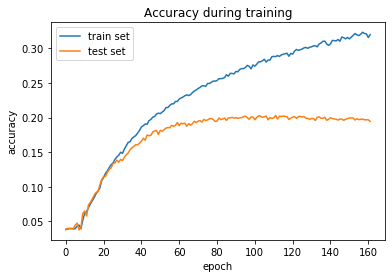

In [16]:
recurrentLayer = SimpleRNN(256, activation="relu", input_shape=(maxTitleLength, vectorLength))
fullyConnectedLayer1 = Dense(256, activation="relu")
fullyConnectedLayer2 = Dense(256, activation="relu")
fullyConnectedLayer3 = Dense(93, activation="softmax")

classifier4 = Sequential([recurrentLayer, fullyConnectedLayer1, fullyConnectedLayer2, fullyConnectedLayer3])
classifier4.compile(loss='categorical_crossentropy', optimizer="adam", metrics=["acc"])

early_stopping = EarlyStopping(monitor='val_acc', mode="max", patience=50, verbose=1)
best_model_saving = ModelCheckpoint("RNN_best_model_4.h5", monitor="val_acc", mode="max", save_best_only=True, verbose=1)

start_time = time()
history4 = classifier4.fit(vectors_train,onehot_train, epochs=5000, batch_size=2048, validation_data=(vectors_test,onehot_test), callbacks=[early_stopping, best_model_saving], verbose=2)
end_time = time()
print("Time elapsed during training: {}".format(end_time - start_time))

classifier4 = load_model("RNN_best_model_4.h5")

_, train_accuracy = classifier4.evaluate(vectors_train, onehot_train, verbose=0)
print("Accuracy on training set: {}".format(train_accuracy))
_, test_accuracy = classifier4.evaluate(vectors_test, onehot_test, verbose=0)
print("Accuracy on held-out test set: {}".format(test_accuracy))

plotFittingAccuracy(history4)

Train on 101134 samples, validate on 25284 samples
Epoch 1/5000
 - 37s - loss: 4.3143 - acc: 0.0341 - val_loss: 4.1607 - val_acc: 0.0401

Epoch 00001: val_acc improved from -inf to 0.04010, saving model to RNN_best_model_5.h5
Epoch 2/5000
 - 35s - loss: 4.1588 - acc: 0.0398 - val_loss: 4.1577 - val_acc: 0.0400

Epoch 00002: val_acc did not improve from 0.04010
Epoch 3/5000
 - 35s - loss: 4.1582 - acc: 0.0394 - val_loss: 4.1575 - val_acc: 0.0380

Epoch 00003: val_acc did not improve from 0.04010
Epoch 4/5000
 - 35s - loss: 4.1578 - acc: 0.0393 - val_loss: 4.1577 - val_acc: 0.0401

Epoch 00004: val_acc did not improve from 0.04010
Epoch 5/5000
 - 35s - loss: 4.1578 - acc: 0.0397 - val_loss: 4.1569 - val_acc: 0.0401

Epoch 00005: val_acc did not improve from 0.04010
Epoch 6/5000
 - 35s - loss: 4.1567 - acc: 0.0386 - val_loss: 4.1562 - val_acc: 0.0400

Epoch 00006: val_acc did not improve from 0.04010
Epoch 7/5000
 - 35s - loss: 4.1567 - acc: 0.0395 - val_loss: 4.1574 - val_acc: 0.0400

Ep


Epoch 00050: val_acc improved from 0.20052 to 0.20139, saving model to RNN_best_model_5.h5
Epoch 51/5000
 - 35s - loss: 3.0397 - acc: 0.2373 - val_loss: 3.3317 - val_acc: 0.2017

Epoch 00051: val_acc improved from 0.20139 to 0.20167, saving model to RNN_best_model_5.h5
Epoch 52/5000
 - 35s - loss: 3.0157 - acc: 0.2427 - val_loss: 3.3428 - val_acc: 0.2009

Epoch 00052: val_acc did not improve from 0.20167
Epoch 53/5000
 - 35s - loss: 3.0069 - acc: 0.2440 - val_loss: 3.3369 - val_acc: 0.2034

Epoch 00053: val_acc improved from 0.20167 to 0.20341, saving model to RNN_best_model_5.h5
Epoch 54/5000
 - 34s - loss: 2.9800 - acc: 0.2498 - val_loss: 3.3120 - val_acc: 0.2076

Epoch 00054: val_acc improved from 0.20341 to 0.20760, saving model to RNN_best_model_5.h5
Epoch 55/5000
 - 36s - loss: 2.9705 - acc: 0.2511 - val_loss: 3.3340 - val_acc: 0.2047

Epoch 00055: val_acc did not improve from 0.20760
Epoch 56/5000
 - 35s - loss: 2.9689 - acc: 0.2517 - val_loss: 3.3825 - val_acc: 0.2005

Epoch 0

 - 35s - loss: 2.5869 - acc: 0.3335 - val_loss: 3.5406 - val_acc: 0.2154

Epoch 00107: val_acc did not improve from 0.22061
Epoch 108/5000
 - 35s - loss: 2.5351 - acc: 0.3454 - val_loss: 3.5035 - val_acc: 0.2193

Epoch 00108: val_acc did not improve from 0.22061
Epoch 109/5000
 - 35s - loss: 2.5316 - acc: 0.3451 - val_loss: 3.5260 - val_acc: 0.2187

Epoch 00109: val_acc did not improve from 0.22061
Epoch 110/5000
 - 35s - loss: 2.5113 - acc: 0.3504 - val_loss: 3.5759 - val_acc: 0.2142

Epoch 00110: val_acc did not improve from 0.22061
Epoch 111/5000
 - 35s - loss: 2.5137 - acc: 0.3499 - val_loss: 3.5288 - val_acc: 0.2167

Epoch 00111: val_acc did not improve from 0.22061
Epoch 112/5000
 - 36s - loss: 2.5153 - acc: 0.3503 - val_loss: 3.5631 - val_acc: 0.2166

Epoch 00112: val_acc did not improve from 0.22061
Epoch 113/5000
 - 35s - loss: 2.5053 - acc: 0.3506 - val_loss: 3.5792 - val_acc: 0.2161

Epoch 00113: val_acc did not improve from 0.22061
Epoch 114/5000
 - 35s - loss: 2.4978 - acc

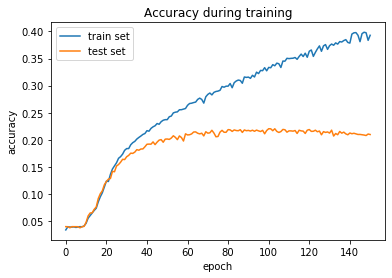

In [17]:
recurrentLayer1 = SimpleRNN(256, activation="relu", input_shape=(maxTitleLength, vectorLength), return_sequences=True)
recurrentLayer2 = SimpleRNN(256, activation="relu")
fullyConnectedLayer1 = Dense(256, activation="relu")
fullyConnectedLayer2 = Dense(256, activation="relu")
fullyConnectedLayer3 = Dense(93, activation="softmax")

classifier5 = Sequential([recurrentLayer1, recurrentLayer2, fullyConnectedLayer1, fullyConnectedLayer2, fullyConnectedLayer3])
classifier5.compile(loss='categorical_crossentropy', optimizer="adam", metrics=["acc"])

early_stopping = EarlyStopping(monitor='val_acc', mode="max", patience=50, verbose=1)
best_model_saving = ModelCheckpoint("RNN_best_model_5.h5", monitor="val_acc", mode="max", save_best_only=True, verbose=1)

start_time = time()
history5 = classifier5.fit(vectors_train,onehot_train, epochs=5000, batch_size=2048, validation_data=(vectors_test,onehot_test), callbacks=[early_stopping, best_model_saving], verbose=2)
end_time = time()
print("Time elapsed during training: {}".format(end_time - start_time))

classifier5 = load_model("RNN_best_model_5.h5")

_, train_accuracy = classifier5.evaluate(vectors_train, onehot_train, verbose=0)
print("Accuracy on training set: {}".format(train_accuracy))
_, test_accuracy = classifier5.evaluate(vectors_test, onehot_test, verbose=0)
print("Accuracy on held-out test set: {}".format(test_accuracy))

plotFittingAccuracy(history5)

More hidden layers were added to the model -- RNN-256-perceptron-256-perceptron-256, RNN-256-RNN-256-perceptron-256. These models did not achieve better performance compared to those with only two hidden layers. Howver, the configuration of RNN-256-RNN-256-perceptron-256-perceptron-256 slightly improved the accuracy on the test set to 22%, which is unfortunately not significant.

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Train on 101134 samples, validate on 25284 samples
Epoch 1/5000
 - 17s - loss: 4.4052 - acc: 0.0381 - val_loss: 4.1849 - val_acc: 0.0378

Epoch 00001: val_acc improved from -inf to 0.03777, saving model to RNN_best_model_6.h5
Epoch 2/5000
 - 16s - loss: 4.1644 - acc: 0.0388 - val_loss: 4.1572 - val_acc: 0.0401

Epoch 00002: val_acc improved from 0.03777 to 0.04010, saving model to RNN_best_model_6.h5
Epoch 3/5000
 - 16s - loss: 4.1587 - acc: 0.0397 - val_loss: 4.1572 - val_acc: 0.0401

Epoch 00003: val_acc did not improve from 0.04010
Epoch 4/5000
 - 16s - loss: 4.1580 - acc: 0.0403 - val_loss: 4.1558 - val_acc: 0.0401

Epoch 00004: val_acc did not improve from 0.04010
Epoch 5/5000
 - 16s - loss: 4.1572 - acc: 0.0398 - val_loss: 4.1551 - val_acc: 0.0425

Epoch 00005: val_acc improved from 0.04010 to 0.04248, saving model to RNN_best_model_6.h5
Epoch 6/5000
 - 16s - loss: 4


Epoch 00048: val_acc improved from 0.15678 to 0.15801, saving model to RNN_best_model_6.h5
Epoch 49/5000
 - 16s - loss: 3.4531 - acc: 0.1715 - val_loss: 3.5431 - val_acc: 0.1592

Epoch 00049: val_acc improved from 0.15801 to 0.15915, saving model to RNN_best_model_6.h5
Epoch 50/5000
 - 16s - loss: 3.4449 - acc: 0.1731 - val_loss: 3.5357 - val_acc: 0.1619

Epoch 00050: val_acc improved from 0.15915 to 0.16192, saving model to RNN_best_model_6.h5
Epoch 51/5000
 - 16s - loss: 3.4252 - acc: 0.1767 - val_loss: 3.5382 - val_acc: 0.1597

Epoch 00051: val_acc did not improve from 0.16192
Epoch 52/5000
 - 16s - loss: 3.4148 - acc: 0.1786 - val_loss: 3.5351 - val_acc: 0.1605

Epoch 00052: val_acc did not improve from 0.16192
Epoch 53/5000
 - 16s - loss: 3.4012 - acc: 0.1816 - val_loss: 3.5351 - val_acc: 0.1644

Epoch 00053: val_acc improved from 0.16192 to 0.16441, saving model to RNN_best_model_6.h5
Epoch 54/5000
 - 16s - loss: 3.3901 - acc: 0.1830 - val_loss: 3.5075 - val_acc: 0.1661

Epoch 0

 - 16s - loss: 3.0182 - acc: 0.2462 - val_loss: 3.4958 - val_acc: 0.1986

Epoch 00099: val_acc did not improve from 0.19949
Epoch 100/5000
 - 16s - loss: 2.9981 - acc: 0.2507 - val_loss: 3.5002 - val_acc: 0.1961

Epoch 00100: val_acc did not improve from 0.19949
Epoch 101/5000
 - 16s - loss: 3.0099 - acc: 0.2479 - val_loss: 3.4740 - val_acc: 0.1987

Epoch 00101: val_acc did not improve from 0.19949
Epoch 102/5000
 - 16s - loss: 2.9915 - acc: 0.2513 - val_loss: 3.4874 - val_acc: 0.1996

Epoch 00102: val_acc improved from 0.19949 to 0.19961, saving model to RNN_best_model_6.h5
Epoch 103/5000
 - 16s - loss: 2.9959 - acc: 0.2516 - val_loss: 3.4875 - val_acc: 0.1999

Epoch 00103: val_acc improved from 0.19961 to 0.19993, saving model to RNN_best_model_6.h5
Epoch 104/5000
 - 16s - loss: 2.9737 - acc: 0.2550 - val_loss: 3.5519 - val_acc: 0.1968

Epoch 00104: val_acc did not improve from 0.19993
Epoch 105/5000
 - 16s - loss: 2.9789 - acc: 0.2541 - val_loss: 3.4811 - val_acc: 0.2013

Epoch 0010


Epoch 00156: val_acc did not improve from 0.20167
Epoch 157/5000
 - 15s - loss: 2.7702 - acc: 0.2929 - val_loss: 3.6657 - val_acc: 0.1982

Epoch 00157: val_acc did not improve from 0.20167
Epoch 158/5000
 - 16s - loss: 2.7463 - acc: 0.2986 - val_loss: 3.7142 - val_acc: 0.1966

Epoch 00158: val_acc did not improve from 0.20167
Epoch 159/5000
 - 15s - loss: 2.7411 - acc: 0.2982 - val_loss: 3.6993 - val_acc: 0.1961

Epoch 00159: val_acc did not improve from 0.20167
Epoch 160/5000
 - 16s - loss: 2.7388 - acc: 0.2991 - val_loss: 3.6736 - val_acc: 0.1963

Epoch 00160: val_acc did not improve from 0.20167
Epoch 161/5000
 - 15s - loss: 2.7297 - acc: 0.3014 - val_loss: 3.6899 - val_acc: 0.1946

Epoch 00161: val_acc did not improve from 0.20167
Epoch 00161: early stopping
Time elapsed during training: 2532.0268847942352
Accuracy on training set: 0.2720351217199933
Accuracy on held-out test set: 0.20166903970890682


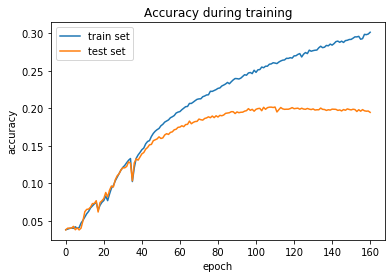

In [18]:
recurrentLayer = SimpleRNN(256, activation="relu", input_shape=(maxTitleLength, vectorLength))
fullyConnectedLayer1 = Dense(256, activation="relu")
fullyConnectedLayer2 = Dense(93, activation="softmax")

classifier6 = Sequential([recurrentLayer, Dropout(0.1), fullyConnectedLayer1, fullyConnectedLayer2])
classifier6.compile(loss='categorical_crossentropy', optimizer="adam", metrics=["acc"])

early_stopping = EarlyStopping(monitor='val_acc', mode="max", patience=50, verbose=1)
best_model_saving = ModelCheckpoint("RNN_best_model_6.h5", monitor="val_acc", mode="max", save_best_only=True, verbose=1)

start_time = time()
history6 = classifier6.fit(vectors_train,onehot_train, epochs=5000, batch_size=2048, validation_data=(vectors_test,onehot_test), callbacks=[early_stopping, best_model_saving], verbose=2)
end_time = time()
print("Time elapsed during training: {}".format(end_time - start_time))

classifier6 = load_model("RNN_best_model_6.h5")

_, train_accuracy = classifier6.evaluate(vectors_train, onehot_train, verbose=0)
print("Accuracy on training set: {}".format(train_accuracy))
_, test_accuracy = classifier6.evaluate(vectors_test, onehot_test, verbose=0)
print("Accuracy on held-out test set: {}".format(test_accuracy))

plotFittingAccuracy(history6)

Train on 101134 samples, validate on 25284 samples
Epoch 1/5000
 - 17s - loss: 4.4191 - acc: 0.0368 - val_loss: 4.2037 - val_acc: 0.0380

Epoch 00001: val_acc improved from -inf to 0.03801, saving model to RNN_best_model_7.h5
Epoch 2/5000
 - 16s - loss: 4.1666 - acc: 0.0398 - val_loss: 4.1589 - val_acc: 0.0401

Epoch 00002: val_acc improved from 0.03801 to 0.04010, saving model to RNN_best_model_7.h5
Epoch 3/5000
 - 16s - loss: 4.1593 - acc: 0.0400 - val_loss: 4.1569 - val_acc: 0.0400

Epoch 00003: val_acc did not improve from 0.04010
Epoch 4/5000
 - 16s - loss: 4.1589 - acc: 0.0395 - val_loss: 4.1568 - val_acc: 0.0401

Epoch 00004: val_acc did not improve from 0.04010
Epoch 5/5000
 - 16s - loss: 4.1580 - acc: 0.0406 - val_loss: 4.1554 - val_acc: 0.0400

Epoch 00005: val_acc did not improve from 0.04010
Epoch 6/5000
 - 16s - loss: 4.1568 - acc: 0.0395 - val_loss: 4.1546 - val_acc: 0.0400

Epoch 00006: val_acc did not improve from 0.04010
Epoch 7/5000
 - 16s - loss: 4.1556 - acc: 0.0407

 - 16s - loss: 3.4195 - acc: 0.1765 - val_loss: 3.5296 - val_acc: 0.1654

Epoch 00049: val_acc improved from 0.16228 to 0.16540, saving model to RNN_best_model_7.h5
Epoch 50/5000
 - 16s - loss: 3.4055 - acc: 0.1789 - val_loss: 3.5535 - val_acc: 0.1607

Epoch 00050: val_acc did not improve from 0.16540
Epoch 51/5000
 - 16s - loss: 3.3973 - acc: 0.1799 - val_loss: 3.5347 - val_acc: 0.1660

Epoch 00051: val_acc improved from 0.16540 to 0.16599, saving model to RNN_best_model_7.h5
Epoch 52/5000
 - 16s - loss: 3.3853 - acc: 0.1834 - val_loss: 3.5081 - val_acc: 0.1698

Epoch 00052: val_acc improved from 0.16599 to 0.16979, saving model to RNN_best_model_7.h5
Epoch 53/5000
 - 16s - loss: 3.3714 - acc: 0.1843 - val_loss: 3.5349 - val_acc: 0.1657

Epoch 00053: val_acc did not improve from 0.16979
Epoch 54/5000
 - 16s - loss: 3.3676 - acc: 0.1857 - val_loss: 3.5103 - val_acc: 0.1695

Epoch 00054: val_acc did not improve from 0.16979
Epoch 55/5000
 - 16s - loss: 3.3594 - acc: 0.1868 - val_loss: 3

 - 16s - loss: 3.0447 - acc: 0.2423 - val_loss: 3.5685 - val_acc: 0.1872

Epoch 00100: val_acc did not improve from 0.19317
Epoch 101/5000
 - 16s - loss: 3.0305 - acc: 0.2443 - val_loss: 3.4811 - val_acc: 0.1944

Epoch 00101: val_acc improved from 0.19317 to 0.19443, saving model to RNN_best_model_7.h5
Epoch 102/5000
 - 16s - loss: 3.0049 - acc: 0.2484 - val_loss: 3.4840 - val_acc: 0.1898

Epoch 00102: val_acc did not improve from 0.19443
Epoch 103/5000
 - 16s - loss: 3.0076 - acc: 0.2494 - val_loss: 3.4861 - val_acc: 0.1936

Epoch 00103: val_acc did not improve from 0.19443
Epoch 104/5000
 - 16s - loss: 3.0010 - acc: 0.2498 - val_loss: 3.4924 - val_acc: 0.1930

Epoch 00104: val_acc did not improve from 0.19443
Epoch 105/5000
 - 16s - loss: 2.9986 - acc: 0.2518 - val_loss: 3.5328 - val_acc: 0.1919

Epoch 00105: val_acc did not improve from 0.19443
Epoch 106/5000
 - 16s - loss: 2.9995 - acc: 0.2510 - val_loss: 3.5163 - val_acc: 0.1921

Epoch 00106: val_acc did not improve from 0.19443
E


Epoch 00158: val_acc did not improve from 0.19550
Epoch 159/5000
 - 16s - loss: 2.8028 - acc: 0.2872 - val_loss: 3.6207 - val_acc: 0.1939

Epoch 00159: val_acc did not improve from 0.19550
Epoch 160/5000
 - 16s - loss: 2.8087 - acc: 0.2857 - val_loss: 3.6529 - val_acc: 0.1935

Epoch 00160: val_acc did not improve from 0.19550
Epoch 161/5000
 - 16s - loss: 2.8089 - acc: 0.2836 - val_loss: 3.6454 - val_acc: 0.1925

Epoch 00161: val_acc did not improve from 0.19550
Epoch 162/5000
 - 16s - loss: 2.7900 - acc: 0.2883 - val_loss: 3.6969 - val_acc: 0.1904

Epoch 00162: val_acc did not improve from 0.19550
Epoch 163/5000
 - 16s - loss: 2.7921 - acc: 0.2878 - val_loss: 3.6642 - val_acc: 0.1898

Epoch 00163: val_acc did not improve from 0.19550
Epoch 164/5000
 - 16s - loss: 2.7991 - acc: 0.2889 - val_loss: 3.6391 - val_acc: 0.1913

Epoch 00164: val_acc did not improve from 0.19550
Epoch 165/5000
 - 16s - loss: 2.7925 - acc: 0.2885 - val_loss: 3.6577 - val_acc: 0.1930

Epoch 00165: val_acc did n

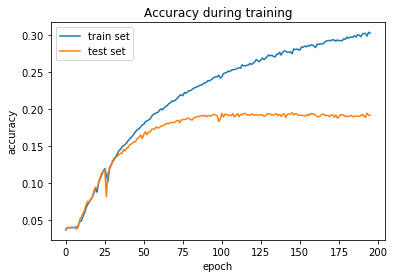

In [19]:
recurrentLayer = SimpleRNN(256, activation="relu", input_shape=(maxTitleLength, vectorLength))
fullyConnectedLayer1 = Dense(256, activation="relu")
fullyConnectedLayer2 = Dense(93, activation="softmax")

classifier7 = Sequential([recurrentLayer, Dropout(0.2), fullyConnectedLayer1, fullyConnectedLayer2])
classifier7.compile(loss='categorical_crossentropy', optimizer="adam", metrics=["acc"])

early_stopping = EarlyStopping(monitor='val_acc', mode="max", patience=50, verbose=1)
best_model_saving = ModelCheckpoint("RNN_best_model_7.h5", monitor="val_acc", mode="max", save_best_only=True, verbose=1)

start_time = time()
history7 = classifier7.fit(vectors_train,onehot_train, epochs=5000, batch_size=2048, validation_data=(vectors_test,onehot_test), callbacks=[early_stopping, best_model_saving], verbose=2)
end_time = time()
print("Time elapsed during training: {}".format(end_time - start_time))

classifier7 = load_model("RNN_best_model_7.h5")

_, train_accuracy = classifier7.evaluate(vectors_train, onehot_train, verbose=0)
print("Accuracy on training set: {}".format(train_accuracy))
_, test_accuracy = classifier7.evaluate(vectors_test, onehot_test, verbose=0)
print("Accuracy on held-out test set: {}".format(test_accuracy))

plotFittingAccuracy(history7)

Train on 101134 samples, validate on 25284 samples
Epoch 1/5000
 - 17s - loss: 4.4205 - acc: 0.0331 - val_loss: 4.1831 - val_acc: 0.0380

Epoch 00001: val_acc improved from -inf to 0.03801, saving model to RNN_best_model_8.h5
Epoch 2/5000
 - 16s - loss: 4.1676 - acc: 0.0384 - val_loss: 4.1568 - val_acc: 0.0401

Epoch 00002: val_acc improved from 0.03801 to 0.04010, saving model to RNN_best_model_8.h5
Epoch 3/5000
 - 16s - loss: 4.1617 - acc: 0.0397 - val_loss: 4.1573 - val_acc: 0.0412

Epoch 00003: val_acc improved from 0.04010 to 0.04121, saving model to RNN_best_model_8.h5
Epoch 4/5000
 - 16s - loss: 4.1596 - acc: 0.0400 - val_loss: 4.1556 - val_acc: 0.0400

Epoch 00004: val_acc did not improve from 0.04121
Epoch 5/5000
 - 16s - loss: 4.1585 - acc: 0.0401 - val_loss: 4.1557 - val_acc: 0.0403

Epoch 00005: val_acc did not improve from 0.04121
Epoch 6/5000
 - 16s - loss: 4.1578 - acc: 0.0397 - val_loss: 4.1547 - val_acc: 0.0436

Epoch 00006: val_acc improved from 0.04121 to 0.04362, sa

 - 16s - loss: 3.4049 - acc: 0.1753 - val_loss: 3.5292 - val_acc: 0.1651

Epoch 00049: val_acc did not improve from 0.16595
Epoch 50/5000
 - 16s - loss: 3.3937 - acc: 0.1764 - val_loss: 3.5099 - val_acc: 0.1679

Epoch 00050: val_acc improved from 0.16595 to 0.16793, saving model to RNN_best_model_8.h5
Epoch 51/5000
 - 16s - loss: 3.3880 - acc: 0.1784 - val_loss: 3.5345 - val_acc: 0.1633

Epoch 00051: val_acc did not improve from 0.16793
Epoch 52/5000
 - 16s - loss: 3.3762 - acc: 0.1790 - val_loss: 3.5183 - val_acc: 0.1664

Epoch 00052: val_acc did not improve from 0.16793
Epoch 53/5000
 - 16s - loss: 3.3638 - acc: 0.1832 - val_loss: 3.5231 - val_acc: 0.1691

Epoch 00053: val_acc improved from 0.16793 to 0.16908, saving model to RNN_best_model_8.h5
Epoch 54/5000
 - 16s - loss: 3.3653 - acc: 0.1809 - val_loss: 3.4976 - val_acc: 0.1710

Epoch 00054: val_acc improved from 0.16908 to 0.17102, saving model to RNN_best_model_8.h5
Epoch 55/5000
 - 16s - loss: 3.3468 - acc: 0.1853 - val_loss: 3


Epoch 00101: val_acc did not improve from 0.19067
Epoch 102/5000
 - 15s - loss: 3.0606 - acc: 0.2348 - val_loss: 3.5344 - val_acc: 0.1864

Epoch 00102: val_acc did not improve from 0.19067
Epoch 103/5000
 - 16s - loss: 3.0487 - acc: 0.2385 - val_loss: 3.5574 - val_acc: 0.1867

Epoch 00103: val_acc did not improve from 0.19067
Epoch 104/5000
 - 16s - loss: 3.0529 - acc: 0.2354 - val_loss: 3.5661 - val_acc: 0.1870

Epoch 00104: val_acc did not improve from 0.19067
Epoch 105/5000
 - 16s - loss: 3.0513 - acc: 0.2372 - val_loss: 3.5378 - val_acc: 0.1899

Epoch 00105: val_acc did not improve from 0.19067
Epoch 106/5000
 - 16s - loss: 3.0381 - acc: 0.2391 - val_loss: 3.5272 - val_acc: 0.1893

Epoch 00106: val_acc did not improve from 0.19067
Epoch 107/5000
 - 16s - loss: 3.0275 - acc: 0.2409 - val_loss: 3.5652 - val_acc: 0.1870

Epoch 00107: val_acc did not improve from 0.19067
Epoch 108/5000
 - 16s - loss: 3.0353 - acc: 0.2393 - val_loss: 3.5322 - val_acc: 0.1878

Epoch 00108: val_acc did n

 - 16s - loss: 2.8523 - acc: 0.2738 - val_loss: 3.6931 - val_acc: 0.1897

Epoch 00160: val_acc did not improve from 0.19253
Epoch 161/5000
 - 16s - loss: 2.8612 - acc: 0.2721 - val_loss: 3.7035 - val_acc: 0.1865

Epoch 00161: val_acc did not improve from 0.19253
Epoch 162/5000
 - 16s - loss: 2.8637 - acc: 0.2709 - val_loss: 3.7008 - val_acc: 0.1896

Epoch 00162: val_acc did not improve from 0.19253
Epoch 163/5000
 - 16s - loss: 2.8767 - acc: 0.2690 - val_loss: 3.6892 - val_acc: 0.1899

Epoch 00163: val_acc did not improve from 0.19253
Epoch 164/5000
 - 16s - loss: 2.8542 - acc: 0.2725 - val_loss: 3.7091 - val_acc: 0.1870

Epoch 00164: val_acc did not improve from 0.19253
Epoch 165/5000
 - 16s - loss: 2.8507 - acc: 0.2731 - val_loss: 3.6883 - val_acc: 0.1869

Epoch 00165: val_acc did not improve from 0.19253
Epoch 166/5000
 - 16s - loss: 2.8604 - acc: 0.2708 - val_loss: 3.7347 - val_acc: 0.1879

Epoch 00166: val_acc did not improve from 0.19253
Epoch 167/5000
 - 16s - loss: 2.8485 - acc

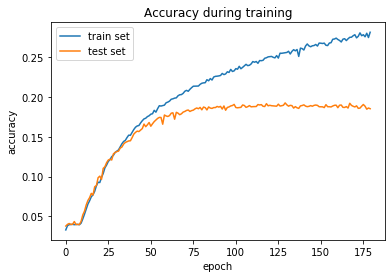

In [20]:
recurrentLayer = SimpleRNN(256, activation="relu", input_shape=(maxTitleLength, vectorLength))
fullyConnectedLayer1 = Dense(256, activation="relu")
fullyConnectedLayer2 = Dense(93, activation="softmax")

classifier8 = Sequential([recurrentLayer, Dropout(0.4), fullyConnectedLayer1, fullyConnectedLayer2])
classifier8.compile(loss='categorical_crossentropy', optimizer="adam", metrics=["acc"])

early_stopping = EarlyStopping(monitor='val_acc', mode="max", patience=50, verbose=1)
best_model_saving = ModelCheckpoint("RNN_best_model_8.h5", monitor="val_acc", mode="max", save_best_only=True, verbose=1)

start_time = time()
history8 = classifier8.fit(vectors_train,onehot_train, epochs=5000, batch_size=2048, validation_data=(vectors_test,onehot_test), callbacks=[early_stopping, best_model_saving], verbose=2)
end_time = time()
print("Time elapsed during training: {}".format(end_time - start_time))

classifier8 = load_model("RNN_best_model_8.h5")

_, train_accuracy = classifier8.evaluate(vectors_train, onehot_train, verbose=0)
print("Accuracy on training set: {}".format(train_accuracy))
_, test_accuracy = classifier8.evaluate(vectors_test, onehot_test, verbose=0)
print("Accuracy on held-out test set: {}".format(test_accuracy))

plotFittingAccuracy(history8)

Train on 101134 samples, validate on 25284 samples
Epoch 1/5000
 - 17s - loss: 4.2639 - acc: 0.0364 - val_loss: 4.1581 - val_acc: 0.0400

Epoch 00001: val_acc improved from -inf to 0.03999, saving model to RNN_best_model_9.h5
Epoch 2/5000
 - 16s - loss: 4.1649 - acc: 0.0394 - val_loss: 4.1566 - val_acc: 0.0401

Epoch 00002: val_acc improved from 0.03999 to 0.04010, saving model to RNN_best_model_9.h5
Epoch 3/5000
 - 16s - loss: 4.1622 - acc: 0.0381 - val_loss: 4.1580 - val_acc: 0.0401

Epoch 00003: val_acc did not improve from 0.04010
Epoch 4/5000
 - 16s - loss: 4.1616 - acc: 0.0390 - val_loss: 4.1582 - val_acc: 0.0412

Epoch 00004: val_acc improved from 0.04010 to 0.04117, saving model to RNN_best_model_9.h5
Epoch 5/5000
 - 16s - loss: 4.1595 - acc: 0.0385 - val_loss: 4.1558 - val_acc: 0.0400

Epoch 00005: val_acc did not improve from 0.04117
Epoch 6/5000
 - 16s - loss: 4.1588 - acc: 0.0384 - val_loss: 4.1567 - val_acc: 0.0400

Epoch 00006: val_acc did not improve from 0.04117
Epoch 7

 - 16s - loss: 3.4441 - acc: 0.1730 - val_loss: 3.5453 - val_acc: 0.1609

Epoch 00049: val_acc improved from 0.15848 to 0.16089, saving model to RNN_best_model_9.h5
Epoch 50/5000
 - 16s - loss: 3.4295 - acc: 0.1760 - val_loss: 3.5347 - val_acc: 0.1622

Epoch 00050: val_acc improved from 0.16089 to 0.16216, saving model to RNN_best_model_9.h5
Epoch 51/5000
 - 16s - loss: 3.4222 - acc: 0.1775 - val_loss: 3.5478 - val_acc: 0.1612

Epoch 00051: val_acc did not improve from 0.16216
Epoch 52/5000
 - 16s - loss: 3.4136 - acc: 0.1790 - val_loss: 3.5265 - val_acc: 0.1648

Epoch 00052: val_acc improved from 0.16216 to 0.16481, saving model to RNN_best_model_9.h5
Epoch 53/5000
 - 16s - loss: 3.3993 - acc: 0.1813 - val_loss: 3.5381 - val_acc: 0.1646

Epoch 00053: val_acc did not improve from 0.16481
Epoch 54/5000
 - 16s - loss: 3.3856 - acc: 0.1840 - val_loss: 3.5433 - val_acc: 0.1647

Epoch 00054: val_acc did not improve from 0.16481
Epoch 55/5000
 - 16s - loss: 3.3759 - acc: 0.1851 - val_loss: 3

 - 16s - loss: 3.0476 - acc: 0.2405 - val_loss: 3.4802 - val_acc: 0.1875

Epoch 00101: val_acc did not improve from 0.18949
Epoch 102/5000
 - 16s - loss: 3.0352 - acc: 0.2415 - val_loss: 3.4696 - val_acc: 0.1911

Epoch 00102: val_acc improved from 0.18949 to 0.19111, saving model to RNN_best_model_9.h5
Epoch 103/5000
 - 16s - loss: 3.0471 - acc: 0.2401 - val_loss: 3.4832 - val_acc: 0.1885

Epoch 00103: val_acc did not improve from 0.19111
Epoch 104/5000
 - 16s - loss: 3.0305 - acc: 0.2423 - val_loss: 3.4762 - val_acc: 0.1915

Epoch 00104: val_acc improved from 0.19111 to 0.19146, saving model to RNN_best_model_9.h5
Epoch 105/5000
 - 16s - loss: 3.0271 - acc: 0.2447 - val_loss: 3.4961 - val_acc: 0.1899

Epoch 00105: val_acc did not improve from 0.19146
Epoch 106/5000
 - 16s - loss: 3.0168 - acc: 0.2457 - val_loss: 3.4744 - val_acc: 0.1889

Epoch 00106: val_acc did not improve from 0.19146
Epoch 107/5000
 - 16s - loss: 3.0193 - acc: 0.2463 - val_loss: 3.5181 - val_acc: 0.1864

Epoch 0010

 - 15s - loss: 2.8104 - acc: 0.2861 - val_loss: 3.6213 - val_acc: 0.1927

Epoch 00158: val_acc did not improve from 0.19550
Epoch 159/5000
 - 15s - loss: 2.8202 - acc: 0.2851 - val_loss: 3.6474 - val_acc: 0.1930

Epoch 00159: val_acc did not improve from 0.19550
Epoch 160/5000
 - 16s - loss: 2.8042 - acc: 0.2880 - val_loss: 3.6349 - val_acc: 0.1932

Epoch 00160: val_acc did not improve from 0.19550
Epoch 161/5000
 - 15s - loss: 2.8069 - acc: 0.2868 - val_loss: 3.6874 - val_acc: 0.1927

Epoch 00161: val_acc did not improve from 0.19550
Epoch 162/5000
 - 16s - loss: 2.8072 - acc: 0.2863 - val_loss: 3.5983 - val_acc: 0.1942

Epoch 00162: val_acc did not improve from 0.19550
Epoch 163/5000
 - 16s - loss: 2.8032 - acc: 0.2878 - val_loss: 3.6302 - val_acc: 0.1939

Epoch 00163: val_acc did not improve from 0.19550
Epoch 164/5000
 - 16s - loss: 2.8195 - acc: 0.2840 - val_loss: 3.6811 - val_acc: 0.1928

Epoch 00164: val_acc did not improve from 0.19550
Epoch 165/5000
 - 16s - loss: 2.8081 - acc

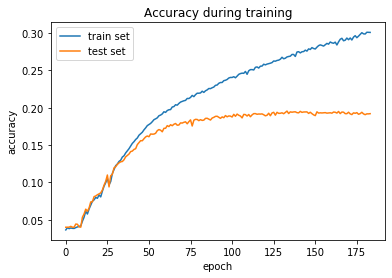

In [21]:
recurrentLayer = SimpleRNN(256, activation="relu", input_shape=(maxTitleLength, vectorLength))
fullyConnectedLayer1 = Dense(256, activation="relu")
fullyConnectedLayer2 = Dense(93, activation="softmax")

classifier9 = Sequential([recurrentLayer, fullyConnectedLayer1, Dropout(0.1), fullyConnectedLayer2])
classifier9.compile(loss='categorical_crossentropy', optimizer="adam", metrics=["acc"])

early_stopping = EarlyStopping(monitor='val_acc', mode="max", patience=50, verbose=1)
best_model_saving = ModelCheckpoint("RNN_best_model_9.h5", monitor="val_acc", mode="max", save_best_only=True, verbose=1)

start_time = time()
history9 = classifier9.fit(vectors_train,onehot_train, epochs=5000, batch_size=2048, validation_data=(vectors_test,onehot_test), callbacks=[early_stopping, best_model_saving], verbose=2)
end_time = time()
print("Time elapsed during training: {}".format(end_time - start_time))

classifier9 = load_model("RNN_best_model_9.h5")

_, train_accuracy = classifier9.evaluate(vectors_train, onehot_train, verbose=0)
print("Accuracy on training set: {}".format(train_accuracy))
_, test_accuracy = classifier9.evaluate(vectors_test, onehot_test, verbose=0)
print("Accuracy on held-out test set: {}".format(test_accuracy))

plotFittingAccuracy(history9)

Train on 101134 samples, validate on 25284 samples
Epoch 1/5000
 - 18s - loss: 4.2713 - acc: 0.0349 - val_loss: 4.1594 - val_acc: 0.0401

Epoch 00001: val_acc improved from -inf to 0.04010, saving model to RNN_best_model_10.h5
Epoch 2/5000
 - 16s - loss: 4.1703 - acc: 0.0394 - val_loss: 4.1577 - val_acc: 0.0401

Epoch 00002: val_acc did not improve from 0.04010
Epoch 3/5000
 - 16s - loss: 4.1654 - acc: 0.0396 - val_loss: 4.1567 - val_acc: 0.0401

Epoch 00003: val_acc did not improve from 0.04010
Epoch 4/5000
 - 16s - loss: 4.1646 - acc: 0.0407 - val_loss: 4.1603 - val_acc: 0.0400

Epoch 00004: val_acc did not improve from 0.04010
Epoch 5/5000
 - 16s - loss: 4.1626 - acc: 0.0393 - val_loss: 4.1575 - val_acc: 0.0403

Epoch 00005: val_acc improved from 0.04010 to 0.04030, saving model to RNN_best_model_10.h5
Epoch 6/5000
 - 16s - loss: 4.1603 - acc: 0.0397 - val_loss: 4.1543 - val_acc: 0.0400

Epoch 00006: val_acc did not improve from 0.04030
Epoch 7/5000
 - 16s - loss: 4.1591 - acc: 0.03

 - 16s - loss: 3.4383 - acc: 0.1705 - val_loss: 3.5520 - val_acc: 0.1566

Epoch 00050: val_acc improved from 0.15563 to 0.15662, saving model to RNN_best_model_10.h5
Epoch 51/5000
 - 16s - loss: 3.4285 - acc: 0.1726 - val_loss: 3.5363 - val_acc: 0.1594

Epoch 00051: val_acc improved from 0.15662 to 0.15939, saving model to RNN_best_model_10.h5
Epoch 52/5000
 - 16s - loss: 3.4014 - acc: 0.1766 - val_loss: 3.5327 - val_acc: 0.1613

Epoch 00052: val_acc improved from 0.15939 to 0.16133, saving model to RNN_best_model_10.h5
Epoch 53/5000
 - 16s - loss: 3.3921 - acc: 0.1766 - val_loss: 3.5477 - val_acc: 0.1607

Epoch 00053: val_acc did not improve from 0.16133
Epoch 54/5000
 - 16s - loss: 3.3869 - acc: 0.1790 - val_loss: 3.5329 - val_acc: 0.1624

Epoch 00054: val_acc improved from 0.16133 to 0.16240, saving model to RNN_best_model_10.h5
Epoch 55/5000
 - 16s - loss: 3.3685 - acc: 0.1823 - val_loss: 3.5077 - val_acc: 0.1665

Epoch 00055: val_acc improved from 0.16240 to 0.16655, saving model 

 - 16s - loss: 3.0211 - acc: 0.2460 - val_loss: 3.5278 - val_acc: 0.1882

Epoch 00100: val_acc did not improve from 0.18846
Epoch 101/5000
 - 16s - loss: 3.0232 - acc: 0.2449 - val_loss: 3.5027 - val_acc: 0.1878

Epoch 00101: val_acc did not improve from 0.18846
Epoch 102/5000
 - 16s - loss: 3.0075 - acc: 0.2476 - val_loss: 3.5138 - val_acc: 0.1893

Epoch 00102: val_acc improved from 0.18846 to 0.18929, saving model to RNN_best_model_10.h5
Epoch 103/5000
 - 16s - loss: 3.0006 - acc: 0.2488 - val_loss: 3.5232 - val_acc: 0.1883

Epoch 00103: val_acc did not improve from 0.18929
Epoch 104/5000
 - 16s - loss: 3.0063 - acc: 0.2472 - val_loss: 3.4917 - val_acc: 0.1894

Epoch 00104: val_acc improved from 0.18929 to 0.18945, saving model to RNN_best_model_10.h5
Epoch 105/5000
 - 16s - loss: 2.9964 - acc: 0.2496 - val_loss: 3.4993 - val_acc: 0.1886

Epoch 00105: val_acc did not improve from 0.18945
Epoch 106/5000
 - 16s - loss: 2.9905 - acc: 0.2513 - val_loss: 3.5254 - val_acc: 0.1884

Epoch 00


Epoch 00157: val_acc did not improve from 0.19150
Epoch 158/5000
 - 16s - loss: 2.7934 - acc: 0.2883 - val_loss: 3.7655 - val_acc: 0.1851

Epoch 00158: val_acc did not improve from 0.19150
Epoch 159/5000
 - 15s - loss: 2.7754 - acc: 0.2919 - val_loss: 3.7034 - val_acc: 0.1901

Epoch 00159: val_acc did not improve from 0.19150
Epoch 160/5000
 - 16s - loss: 2.7504 - acc: 0.2965 - val_loss: 3.6990 - val_acc: 0.1892

Epoch 00160: val_acc did not improve from 0.19150
Epoch 161/5000
 - 16s - loss: 2.7474 - acc: 0.2974 - val_loss: 3.7772 - val_acc: 0.1874

Epoch 00161: val_acc did not improve from 0.19150
Epoch 162/5000
 - 16s - loss: 2.7685 - acc: 0.2913 - val_loss: 3.7659 - val_acc: 0.1888

Epoch 00162: val_acc did not improve from 0.19150
Epoch 163/5000
 - 16s - loss: 2.7447 - acc: 0.2981 - val_loss: 3.7331 - val_acc: 0.1889

Epoch 00163: val_acc did not improve from 0.19150
Epoch 164/5000
 - 15s - loss: 2.7494 - acc: 0.2965 - val_loss: 3.7172 - val_acc: 0.1873

Epoch 00164: val_acc did n

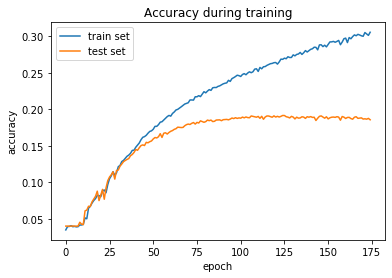

In [22]:
recurrentLayer = SimpleRNN(256, activation="relu", input_shape=(maxTitleLength, vectorLength))
fullyConnectedLayer1 = Dense(256, activation="relu")
fullyConnectedLayer2 = Dense(93, activation="softmax")

classifier10 = Sequential([recurrentLayer, fullyConnectedLayer1, Dropout(0.2), fullyConnectedLayer2])
classifier10.compile(loss='categorical_crossentropy', optimizer="adam", metrics=["acc"])

early_stopping = EarlyStopping(monitor='val_acc', mode="max", patience=50, verbose=1)
best_model_saving = ModelCheckpoint("RNN_best_model_10.h5", monitor="val_acc", mode="max", save_best_only=True, verbose=1)

start_time = time()
history10 = classifier10.fit(vectors_train,onehot_train, epochs=5000, batch_size=2048, validation_data=(vectors_test,onehot_test), callbacks=[early_stopping, best_model_saving], verbose=2)
end_time = time()
print("Time elapsed during training: {}".format(end_time - start_time))

classifier10 = load_model("RNN_best_model_10.h5")

_, train_accuracy = classifier10.evaluate(vectors_train, onehot_train, verbose=0)
print("Accuracy on training set: {}".format(train_accuracy))
_, test_accuracy = classifier10.evaluate(vectors_test, onehot_test, verbose=0)
print("Accuracy on held-out test set: {}".format(test_accuracy))

plotFittingAccuracy(history10)

Train on 101134 samples, validate on 25284 samples
Epoch 1/5000
 - 18s - loss: 4.3929 - acc: 0.0338 - val_loss: 4.1626 - val_acc: 0.0401

Epoch 00001: val_acc improved from -inf to 0.04010, saving model to RNN_best_model_11.h5
Epoch 2/5000
 - 16s - loss: 4.1784 - acc: 0.0379 - val_loss: 4.1570 - val_acc: 0.0406

Epoch 00002: val_acc improved from 0.04010 to 0.04058, saving model to RNN_best_model_11.h5
Epoch 3/5000
 - 16s - loss: 4.1701 - acc: 0.0398 - val_loss: 4.1565 - val_acc: 0.0401

Epoch 00003: val_acc did not improve from 0.04058
Epoch 4/5000
 - 15s - loss: 4.1673 - acc: 0.0391 - val_loss: 4.1593 - val_acc: 0.0400

Epoch 00004: val_acc did not improve from 0.04058
Epoch 5/5000
 - 16s - loss: 4.1659 - acc: 0.0384 - val_loss: 4.1557 - val_acc: 0.0400

Epoch 00005: val_acc did not improve from 0.04058
Epoch 6/5000
 - 16s - loss: 4.1626 - acc: 0.0397 - val_loss: 4.1551 - val_acc: 0.0401

Epoch 00006: val_acc did not improve from 0.04058
Epoch 7/5000
 - 16s - loss: 4.1616 - acc: 0.03

 - 16s - loss: 3.5862 - acc: 0.1432 - val_loss: 3.6281 - val_acc: 0.1357

Epoch 00051: val_acc did not improve from 0.13629
Epoch 52/5000
 - 16s - loss: 3.5807 - acc: 0.1456 - val_loss: 3.6267 - val_acc: 0.1385

Epoch 00052: val_acc improved from 0.13629 to 0.13851, saving model to RNN_best_model_11.h5
Epoch 53/5000
 - 16s - loss: 3.5644 - acc: 0.1495 - val_loss: 3.6059 - val_acc: 0.1419

Epoch 00053: val_acc improved from 0.13851 to 0.14195, saving model to RNN_best_model_11.h5
Epoch 54/5000
 - 16s - loss: 3.5512 - acc: 0.1516 - val_loss: 3.5951 - val_acc: 0.1452

Epoch 00054: val_acc improved from 0.14195 to 0.14515, saving model to RNN_best_model_11.h5
Epoch 55/5000
 - 16s - loss: 3.5445 - acc: 0.1514 - val_loss: 3.5860 - val_acc: 0.1468

Epoch 00055: val_acc improved from 0.14515 to 0.14677, saving model to RNN_best_model_11.h5
Epoch 56/5000
 - 16s - loss: 3.5291 - acc: 0.1550 - val_loss: 3.5827 - val_acc: 0.1474

Epoch 00056: val_acc improved from 0.14677 to 0.14741, saving model 

 - 16s - loss: 3.2060 - acc: 0.2109 - val_loss: 3.4540 - val_acc: 0.1841

Epoch 00101: val_acc did not improve from 0.18462
Epoch 102/5000
 - 16s - loss: 3.1977 - acc: 0.2114 - val_loss: 3.4347 - val_acc: 0.1850

Epoch 00102: val_acc improved from 0.18462 to 0.18502, saving model to RNN_best_model_11.h5
Epoch 103/5000
 - 16s - loss: 3.1836 - acc: 0.2147 - val_loss: 3.4450 - val_acc: 0.1845

Epoch 00103: val_acc did not improve from 0.18502
Epoch 104/5000
 - 16s - loss: 3.1776 - acc: 0.2152 - val_loss: 3.4329 - val_acc: 0.1861

Epoch 00104: val_acc improved from 0.18502 to 0.18609, saving model to RNN_best_model_11.h5
Epoch 105/5000
 - 16s - loss: 3.1810 - acc: 0.2142 - val_loss: 3.4376 - val_acc: 0.1859

Epoch 00105: val_acc did not improve from 0.18609
Epoch 106/5000
 - 16s - loss: 3.1733 - acc: 0.2160 - val_loss: 3.4545 - val_acc: 0.1843

Epoch 00106: val_acc did not improve from 0.18609
Epoch 107/5000
 - 16s - loss: 3.1682 - acc: 0.2177 - val_loss: 3.4411 - val_acc: 0.1867

Epoch 00

 - 16s - loss: 2.9561 - acc: 0.2569 - val_loss: 3.5291 - val_acc: 0.1917

Epoch 00157: val_acc did not improve from 0.19321
Epoch 158/5000
 - 16s - loss: 2.9557 - acc: 0.2575 - val_loss: 3.5098 - val_acc: 0.1936

Epoch 00158: val_acc improved from 0.19321 to 0.19364, saving model to RNN_best_model_11.h5
Epoch 159/5000
 - 16s - loss: 2.9514 - acc: 0.2572 - val_loss: 3.5203 - val_acc: 0.1922

Epoch 00159: val_acc did not improve from 0.19364
Epoch 160/5000
 - 16s - loss: 2.9565 - acc: 0.2571 - val_loss: 3.5342 - val_acc: 0.1923

Epoch 00160: val_acc did not improve from 0.19364
Epoch 161/5000
 - 16s - loss: 2.9421 - acc: 0.2597 - val_loss: 3.5074 - val_acc: 0.1927

Epoch 00161: val_acc did not improve from 0.19364
Epoch 162/5000
 - 16s - loss: 2.9391 - acc: 0.2590 - val_loss: 3.5475 - val_acc: 0.1915

Epoch 00162: val_acc did not improve from 0.19364
Epoch 163/5000
 - 16s - loss: 2.9317 - acc: 0.2610 - val_loss: 3.5667 - val_acc: 0.1896

Epoch 00163: val_acc did not improve from 0.19364



Epoch 00215: val_acc did not improve from 0.19518
Epoch 216/5000
 - 16s - loss: 2.8016 - acc: 0.2881 - val_loss: 3.6690 - val_acc: 0.1952

Epoch 00216: val_acc improved from 0.19518 to 0.19522, saving model to RNN_best_model_11.h5
Epoch 217/5000
 - 16s - loss: 2.7927 - acc: 0.2891 - val_loss: 3.6582 - val_acc: 0.1944

Epoch 00217: val_acc did not improve from 0.19522
Epoch 218/5000
 - 16s - loss: 2.7942 - acc: 0.2895 - val_loss: 3.6715 - val_acc: 0.1929

Epoch 00218: val_acc did not improve from 0.19522
Epoch 219/5000
 - 16s - loss: 2.7895 - acc: 0.2904 - val_loss: 3.6853 - val_acc: 0.1920

Epoch 00219: val_acc did not improve from 0.19522
Epoch 220/5000
 - 16s - loss: 2.7857 - acc: 0.2911 - val_loss: 3.6965 - val_acc: 0.1945

Epoch 00220: val_acc did not improve from 0.19522
Epoch 221/5000
 - 16s - loss: 2.7902 - acc: 0.2893 - val_loss: 3.6918 - val_acc: 0.1933

Epoch 00221: val_acc did not improve from 0.19522
Epoch 222/5000
 - 16s - loss: 2.7896 - acc: 0.2894 - val_loss: 3.6700 - v

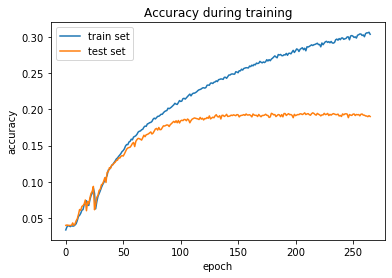

In [23]:
recurrentLayer = SimpleRNN(256, activation="relu", input_shape=(maxTitleLength, vectorLength))
fullyConnectedLayer1 = Dense(256, activation="relu")
fullyConnectedLayer2 = Dense(93, activation="softmax")

classifier11 = Sequential([recurrentLayer, fullyConnectedLayer1, Dropout(0.4), fullyConnectedLayer2])
classifier11.compile(loss='categorical_crossentropy', optimizer="adam", metrics=["acc"])

early_stopping = EarlyStopping(monitor='val_acc', mode="max", patience=50, verbose=1)
best_model_saving = ModelCheckpoint("RNN_best_model_11.h5", monitor="val_acc", mode="max", save_best_only=True, verbose=1)

start_time = time()
history11 = classifier11.fit(vectors_train,onehot_train, epochs=5000, batch_size=2048, validation_data=(vectors_test,onehot_test), callbacks=[early_stopping, best_model_saving], verbose=2)
end_time = time()
print("Time elapsed during training: {}".format(end_time - start_time))

classifier11 = load_model("RNN_best_model_11.h5")

_, train_accuracy = classifier11.evaluate(vectors_train, onehot_train, verbose=0)
print("Accuracy on training set: {}".format(train_accuracy))
_, test_accuracy = classifier11.evaluate(vectors_test, onehot_test, verbose=0)
print("Accuracy on held-out test set: {}".format(test_accuracy))

plotFittingAccuracy(history11)

Train on 101134 samples, validate on 25284 samples
Epoch 1/5000
 - 18s - loss: 4.4098 - acc: 0.0345 - val_loss: 4.1696 - val_acc: 0.0378

Epoch 00001: val_acc improved from -inf to 0.03777, saving model to RNN_best_model_12.h5
Epoch 2/5000
 - 16s - loss: 4.1733 - acc: 0.0387 - val_loss: 4.1631 - val_acc: 0.0404

Epoch 00002: val_acc improved from 0.03777 to 0.04042, saving model to RNN_best_model_12.h5
Epoch 3/5000
 - 16s - loss: 4.1663 - acc: 0.0384 - val_loss: 4.1579 - val_acc: 0.0403

Epoch 00003: val_acc did not improve from 0.04042
Epoch 4/5000
 - 16s - loss: 4.1644 - acc: 0.0390 - val_loss: 4.1556 - val_acc: 0.0425

Epoch 00004: val_acc improved from 0.04042 to 0.04252, saving model to RNN_best_model_12.h5
Epoch 5/5000
 - 16s - loss: 4.1620 - acc: 0.0395 - val_loss: 4.1557 - val_acc: 0.0401

Epoch 00005: val_acc did not improve from 0.04252
Epoch 6/5000
 - 16s - loss: 4.1598 - acc: 0.0407 - val_loss: 4.1544 - val_acc: 0.0400

Epoch 00006: val_acc did not improve from 0.04252
Epoc


Epoch 00049: val_acc did not improve from 0.15413
Epoch 50/5000
 - 16s - loss: 3.4973 - acc: 0.1598 - val_loss: 3.5624 - val_acc: 0.1539

Epoch 00050: val_acc did not improve from 0.15413
Epoch 51/5000
 - 16s - loss: 3.4862 - acc: 0.1631 - val_loss: 3.5432 - val_acc: 0.1577

Epoch 00051: val_acc improved from 0.15413 to 0.15769, saving model to RNN_best_model_12.h5
Epoch 52/5000
 - 16s - loss: 3.4812 - acc: 0.1633 - val_loss: 3.5548 - val_acc: 0.1548

Epoch 00052: val_acc did not improve from 0.15769
Epoch 53/5000
 - 16s - loss: 3.4674 - acc: 0.1652 - val_loss: 3.5445 - val_acc: 0.1588

Epoch 00053: val_acc improved from 0.15769 to 0.15884, saving model to RNN_best_model_12.h5
Epoch 54/5000
 - 16s - loss: 3.4649 - acc: 0.1658 - val_loss: 3.5568 - val_acc: 0.1570

Epoch 00054: val_acc did not improve from 0.15884
Epoch 55/5000
 - 16s - loss: 3.4543 - acc: 0.1678 - val_loss: 3.5409 - val_acc: 0.1619

Epoch 00055: val_acc improved from 0.15884 to 0.16188, saving model to RNN_best_model_1

 - 16s - loss: 3.1285 - acc: 0.2230 - val_loss: 3.4661 - val_acc: 0.1891

Epoch 00101: val_acc did not improve from 0.19091
Epoch 102/5000
 - 16s - loss: 3.1299 - acc: 0.2235 - val_loss: 3.4579 - val_acc: 0.1889

Epoch 00102: val_acc did not improve from 0.19091
Epoch 103/5000
 - 16s - loss: 3.1159 - acc: 0.2250 - val_loss: 3.4412 - val_acc: 0.1904

Epoch 00103: val_acc did not improve from 0.19091
Epoch 104/5000
 - 16s - loss: 3.1141 - acc: 0.2264 - val_loss: 3.4547 - val_acc: 0.1897

Epoch 00104: val_acc did not improve from 0.19091
Epoch 105/5000
 - 16s - loss: 3.1116 - acc: 0.2278 - val_loss: 3.4437 - val_acc: 0.1916

Epoch 00105: val_acc improved from 0.19091 to 0.19162, saving model to RNN_best_model_12.h5
Epoch 106/5000
 - 16s - loss: 3.1012 - acc: 0.2276 - val_loss: 3.4452 - val_acc: 0.1915

Epoch 00106: val_acc did not improve from 0.19162
Epoch 107/5000
 - 16s - loss: 3.1068 - acc: 0.2265 - val_loss: 3.4529 - val_acc: 0.1927

Epoch 00107: val_acc improved from 0.19162 to 0.19


Epoch 00156: val_acc did not improve from 0.19787
Epoch 157/5000
 - 16s - loss: 2.9171 - acc: 0.2626 - val_loss: 3.5527 - val_acc: 0.1952

Epoch 00157: val_acc did not improve from 0.19787
Epoch 158/5000
 - 15s - loss: 2.8970 - acc: 0.2661 - val_loss: 3.5544 - val_acc: 0.1965

Epoch 00158: val_acc did not improve from 0.19787
Epoch 159/5000
 - 16s - loss: 2.8927 - acc: 0.2665 - val_loss: 3.5910 - val_acc: 0.1964

Epoch 00159: val_acc did not improve from 0.19787
Epoch 160/5000
 - 16s - loss: 2.9006 - acc: 0.2667 - val_loss: 3.5704 - val_acc: 0.1947

Epoch 00160: val_acc did not improve from 0.19787
Epoch 161/5000
 - 16s - loss: 2.8925 - acc: 0.2668 - val_loss: 3.5630 - val_acc: 0.1955

Epoch 00161: val_acc did not improve from 0.19787
Epoch 162/5000
 - 16s - loss: 2.8828 - acc: 0.2689 - val_loss: 3.5834 - val_acc: 0.1947

Epoch 00162: val_acc did not improve from 0.19787
Epoch 163/5000
 - 16s - loss: 2.8896 - acc: 0.2663 - val_loss: 3.5597 - val_acc: 0.1959

Epoch 00163: val_acc did n

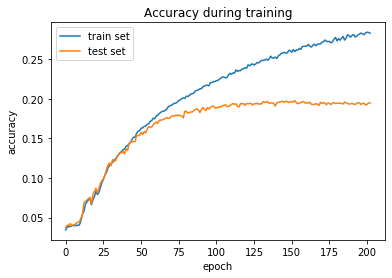

In [24]:
recurrentLayer = SimpleRNN(256, activation="relu", input_shape=(maxTitleLength, vectorLength))
fullyConnectedLayer1 = Dense(256, activation="relu")
fullyConnectedLayer2 = Dense(93, activation="softmax")

classifier12 = Sequential([recurrentLayer, Dropout(0.2), fullyConnectedLayer1, Dropout(0.2), fullyConnectedLayer2])
classifier12.compile(loss='categorical_crossentropy', optimizer="adam", metrics=["acc"])

early_stopping = EarlyStopping(monitor='val_acc', mode="max", patience=50, verbose=1)
best_model_saving = ModelCheckpoint("RNN_best_model_12.h5", monitor="val_acc", mode="max", save_best_only=True, verbose=1)

start_time = time()
history12 = classifier12.fit(vectors_train,onehot_train, epochs=5000, batch_size=2048, validation_data=(vectors_test,onehot_test), callbacks=[early_stopping, best_model_saving], verbose=2)
end_time = time()
print("Time elapsed during training: {}".format(end_time - start_time))

classifier12 = load_model("RNN_best_model_12.h5")

_, train_accuracy = classifier12.evaluate(vectors_train, onehot_train, verbose=0)
print("Accuracy on training set: {}".format(train_accuracy))
_, test_accuracy = classifier12.evaluate(vectors_test, onehot_test, verbose=0)
print("Accuracy on held-out test set: {}".format(test_accuracy))

plotFittingAccuracy(history12)

Various levels of dropout were introduced to the network at different layers; it did not improve the performance of the network either.

# Evaluation

In [25]:
def reveseOneHot(prediction_output):
    integer_encode = onehot_encoder.inverse_transform(prediction_output).flatten().astype(int)
    return integer_encoder.inverse_transform(integer_encode)    

In [26]:
classifier = classifier5

onehot_pred = classifier.predict(vectors_test)
y_pred = reveseOneHot(onehot_pred)

In [27]:
def plotConfusionMatrix(confusionMatrix, classes):
    
    confusionMatrix = confusionMatrix.astype('float') / confusionMatrix.sum(axis=1)[:, np.newaxis]
    
    heatmap_df = pd.DataFrame(confusionMatrix, index=classes, columns=classes)
    
    fig, ax = plt.subplots(figsize=(16,13))
    sns.heatmap(heatmap_df, xticklabels=True,yticklabels=True, ax=ax, vmin=0,vmax=1)
    ax.set_aspect("equal")
    plt.title("Confusion Matrix", fontsize=20)
    plt.ylabel("true category", fontsize=15)
    plt.xlabel("predicted category", fontsize=15)

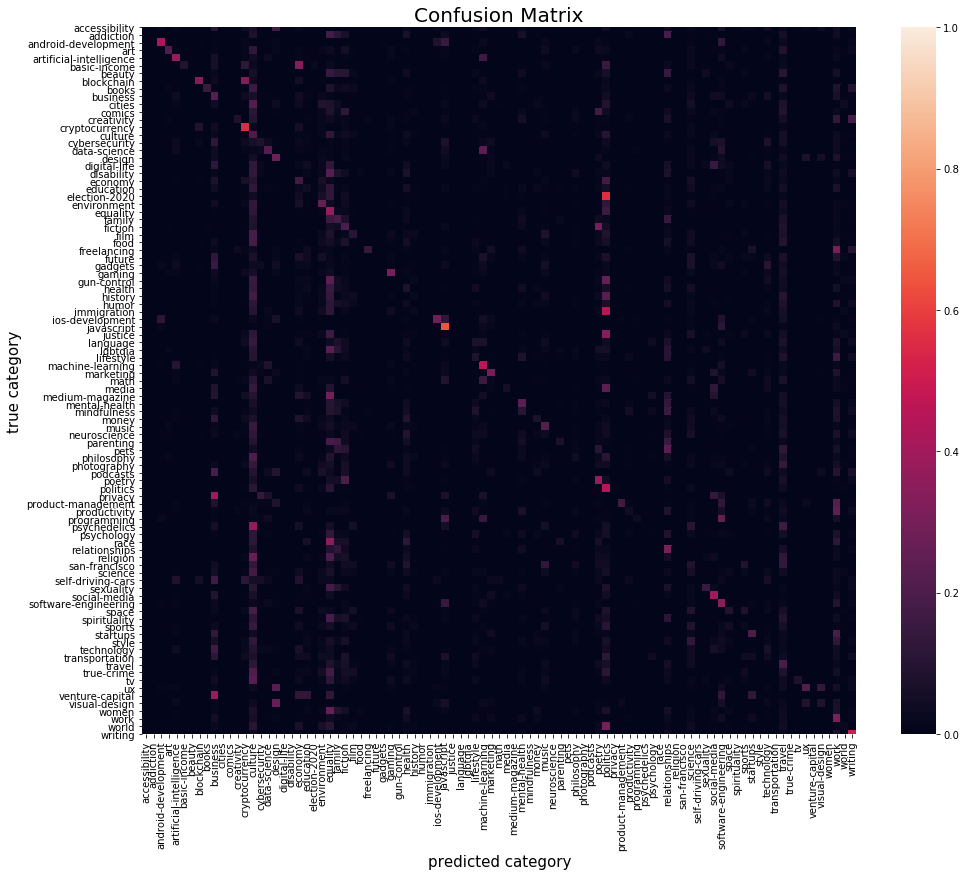

In [28]:
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

category_list = unique_labels(y_test, y_pred)

cMatrix = confusion_matrix(y_test, y_pred, labels=category_list)

plotConfusionMatrix(cMatrix, category_list)

In [29]:
def precisionFromConfusionMatrix(confusionMatrix):
    
    truePos = np.diagonal(confusionMatrix)
    falsePos = np.asarray(confusionMatrix.sum(axis=0)) - truePos
    
    precision = truePos / (truePos + falsePos)
    precision = precision[~np.isnan(precision)]
    
    return precision.mean()

precision = precisionFromConfusionMatrix(cMatrix)
print("Average multiclass precision: {}".format(precision))

Average multiclass precision: 0.2178055692405422
